In [1]:
import numpy as np
from filterpy.kalman import KalmanFilter
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import scipy.stats as sa
import scipy.linalg as la

In [2]:
# Data cleaning
df = pd.read_csv("Cleaned Datasets/US_Full_Quarterly.csv")
df["Log GDP"] = np.log(df["GDP"])
df['Diff Log GDP'] = df['Log GDP'] - df['Log GDP'].shift(1)
df["Log Inv"] = np.log(df["Inv"])
df["Diff Log Inv"] = df["Log Inv"] - df["Log Inv"].shift(1)
df["Log Dependency"] = np.log(df["Dependency"])
for i in range(1,4):
    df["Log Dependency"]+= np.log(df["Dependency"].shift(i))
df["Log Dependency"] /= 4

df["Diff Log Dependency"] = df["Log Dependency"] - df["Log Dependency"].shift(4)
df.set_index("DATE", drop=True, inplace=True)
df.dropna(inplace=True)

# Split the data into train and test
train = df[df.index <= "2000"]
test = df[df.index > "2000"]
train

,GDP,Inv,Exp,Imp,Gov,Cons,NXP,Fertility,Unemployment,Life_exp,...,recession_1990,recession_2001,recession_2008,recession_2020,Log GDP,Diff Log GDP,Log Inv,Diff Log Inv,Log Dependency,Diff Log Dependency
DATE,,,,,,,,,,,,,,,,,,,,,
1961-10-01,580.612,92.931,28.442,23.870,102.076,346.5,4.572,3.6200,6.5,70.270732,...,0,0,0,0,6.364083,0.022553,4.531857,0.021910,2.745684,0.011593
1962-01-01,594.013,98.074,28.325,24.314,105.952,353.2,4.011,3.4610,5.8,70.119512,...,0,0,0,0,6.386901,0.022818,4.585722,0.053865,2.747014,0.010024
1962-04-01,600.366,96.706,29.662,24.884,107.795,359.0,4.778,3.4610,5.6,70.119512,...,0,0,0,0,6.397539,0.010638,4.571675,-0.014047,2.748343,0.008456
1962-07-01,609.027,98.160,29.593,25.111,109.320,361.4,4.482,3.4610,5.4,70.119512,...,0,0,0,0,6.411863,0.014323,4.586599,0.014923,2.749673,0.006888
1962-10-01,612.280,94.968,28.683,25.550,111.161,366.5,3.133,3.4610,5.4,70.119512,...,0,0,0,0,6.417190,0.005327,4.553540,-0.033059,2.751003,0.005319
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1998-10-01,9293.991,1796.964,966.337,1145.000,1814.518,5998.8,-178.663,1.9990,4.5,76.580488,...,1,0,0,0,9.137123,0.018778,7.493854,0.031281,2.938932,-0.005895
1999-01-01,9411.682,1853.063,960.764,1173.324,1811.988,6073.9,-212.560,2.0075,4.3,76.582927,...,1,0,0,0,9.149707,0.012584,7.524595,0.030741,2.937129,-0.006225
1999-04-01,9526.210,1848.341,974.597,1222.126,1816.961,6199.5,-247.529,2.0075,4.3,76.582927,...,1,0,0,0,9.161802,0.012095,7.522044,-0.002551,2.935325,-0.006555


In [3]:
# Define some global variables
d = 1
#data = df[["Diff Log GDP", "Diff Log Dependency", "Log Inv"]]
data = train[['GDP']]
zMatrix = data.to_numpy()
Q = np.eye(d)*.1
R = np.eye(d)*.1
x0 = zMatrix[0]

def Likelihood(X):
    # Unpack the values
    dim_x = d
    dim_z = d

    dimF = dim_x**2
    dimH = dim_x * dim_z

    F, H = X[:dimF].reshape(dim_x, dim_x), X[dimF:dimF+dimH].reshape(dim_x, dim_z)
    xhat = x0.copy()
    Phat = np.eye(d).ravel()*1000
    logLikelis = []
    # Calculate the log-likelihood for each point.
    for i in range(zMatrix.shape[0]):
        # Predict the x value
        xhat = F@xhat
        # Predict the P value
        Phat = F@Phat@(F.T) + Q
        mean = H@xhat
        cov = H@Phat@(H.T) + R
        likelihood = sa.multivariate_normal.pdf(zMatrix[i], mean=mean, cov=cov, allow_singular=True)
        logLikelis.append(likelihood)

    return -1*np.sum(logLikelis)

In [4]:
d = 1
# Initialize Parameters. The initialization of F and H are really sensitive to initial conditions.
#F = np.random.normal(size=(d,d)).ravel()
#H = np.random.normal(size=(d,d)).ravel()
# It is reasonable to initialize F and H both to 1
F = np.array([1])
H = np.array([1])
X = np.hstack((F, H))

# Minimize and unpack values
X = minimize(Likelihood, X, method="bfgs", tol=1e-8).x
dim_x = d
dim_z = d

dimF = dim_x**2
dimH = dim_x * dim_z

F, H = X[:dimF].reshape(dim_x, dim_x), X[dimF:].reshape(dim_x, dim_z)
print(f"F:\n{F}")
print(f"H:\n{H}")

F:
[[1.02112289]]
H:
[[0.92378805]]


In [5]:
def filter(f,zs):
    n = np.size(zs,0)
    # initialize
    xhat = np.zeros((n,f.dim_x,1))
    Ps = np.zeros((n,f.dim_x,f.dim_x))
    z_filtered = np.zeros((n,f.dim_z))
    for i,z in enumerate(zs):
        f.predict()
        f.update(z)
        xhat[i] = f.x.copy()
        Ps[i] = f.P.copy()
        z_filtered[i] = (f.H)@(xhat[i].reshape(f.dim_x,))
        
    return xhat, Ps, z_filtered

def predict(f, zs, stepsForward):
    xhat, Ps, z_filtered = filter(f, zs)
    xhat_predict = np.zeros((stepsForward, f.dim_x, 1))
    Ps_predict = np.zeros((stepsForward, f.dim_x, f.dim_x))
    z_predicts = np.zeros((stepsForward, f.dim_z))

    for i in range(stepsForward):
        f.predict()
        xhat_predict[i] = f.x.copy()
        Ps[i] = f.P.copy()
        z_predicts[i] = (f.H)@(xhat_predict[i].reshape(f.dim_x,))
    
    return np.vstack((xhat, xhat_predict)), 0, np.vstack((z_filtered, z_predicts))

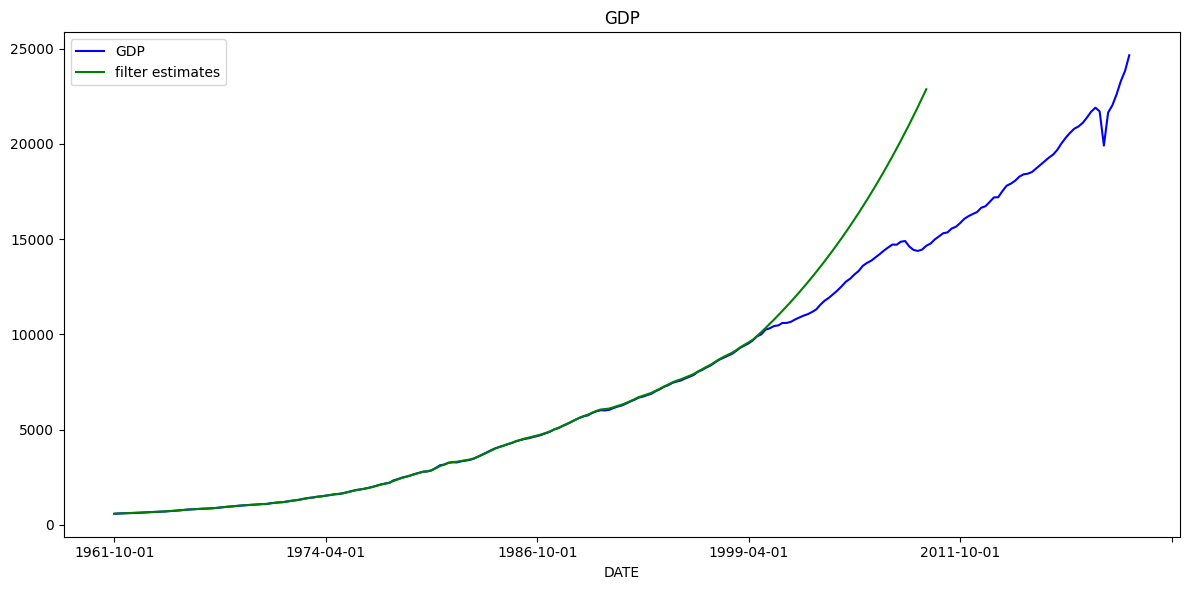

In [29]:
def KalmanFilterTrainAndGraph(train, fullData, F, H, Q, R, x0, y="Diff Log GDP", stepsForward=0):
    # Format the data
    data = train.copy()
    var1 = 'Diff Log Dependency'
    var2 = 'Log Inv'
    #data = data[[y, var1, var2]]
    data = data[[y]]

    # Train the model, calculate the optimal dimension and parameters

    f = KalmanFilter(dim_x=d, dim_z=len(data.columns), dim_u=1)
    f.x = x0.copy().reshape(-1,1)
    f.F = F.copy()
    f.H = H.copy()
    f.Q = Q.copy()
    f.R = R.copy()

    xhat, Ps, z_predicts = predict(f, zMatrix, stepsForward)

    # Plot the results
    fig, axs = plt.subplots(1,1,figsize=(12,6))


    mask = fullData.index > '2000'
    fullData[[y]].plot(ax=axs, label="Original Data", markersize=2, linestyle='-', color="b")
    trainingLength = len(fullData.index)
    testingLength = z_predicts.size - trainingLength

    axs.plot(np.arange(z_predicts.size), z_predicts, label='filter estimates', color="g")
    axs.set_title(y)
    axs.legend()

    #data[[var1]].plot(ax=axs[1], color='b', marker='o', label="Original Data", markersize=2, linestyle='none')
    #axs[1].plot(np.arange(z_predicts[:,1].size), z_predicts[:,1], label='filter estimates', color="r")
    #axs[1].set_title(var1)
    #axs[1].legend()

    #data[[var2]].plot(ax=axs[2], color='b', marker='o', label="Original Data", markersize=2, linestyle='none')
    #axs[2].plot(np.arange(z_predicts[:,2].size), z_predicts[:,2], label='filter estimates', color="r")
    #axs[2].set_title(var2)
    #axs[2].legend()

    plt.legend()
    plt.tight_layout()

    return axs

axs = KalmanFilterTrainAndGraph(train, df, y="GDP", F=F, H=H, Q=Q, R=R, x0=x0, stepsForward=40)